# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify Project") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Load Dataset

In [3]:
# read the data from the json file
df_org = spark.read.json("mini_sparkify_event_data.json")

# using df to dicovery data
df = df_org 

In [4]:
df.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [5]:
# number of rows and columns in the data
print("The number of rows in the dataframe: {}".format(df.count()))
print("The number of columns in the dataframe: {}".format(len(df.columns)))

The number of rows in the dataframe: 286500
The number of columns in the dataframe: 18


In [6]:
# show the columns of the data
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Clean Dataset

In [7]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [8]:
# clean null value of set data userId and sessionId.
df = df.dropna(how='any', subset=['userId', 'sessionId'])
df.count()

286500

↑It seems like there is no null value for userId and sessionId. Let's check these columns:

In [9]:
# check null value of all column
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [10]:
# check blank value of all column
df.select([F.count(F.when(F.col(c) == "", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



There are many records of userId which is a empty string. As empty userId means the user is not log in to the application, we don't need to keep these data as it does not relevant to customer churn.

In [11]:
df = df.filter(df["userId"] != "")
df.count()

278154

# Exploratory Data Analysis

When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# udf to convert the ts to timestamp
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# apply this udf in the dataframe with your timestamp
df = df.withColumn("datetime", get_timestamp(df.ts))

# drop the ts column
df = df.drop("ts")

df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+--------------------+------+-------------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           userAgent|userId|           datetime|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+--------------------+------+-------------------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

### Define Churn
We create a churn column and set it as 1 if user has a session that contains "cancellation confirmation" page type.



In [13]:
df = df.withColumn(
    "Churn",
    F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0)
)

In [14]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+--------------------+------+-------------------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           userAgent|userId|           datetime|Churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+--------------------+------+-------------------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

### Explorer Data

To understand the data we should try to answer below question:

- Difference between "free" and "paid" users in churn rate?
- What difference between "F" and "M" users in churn rate?
- What time in a day/month does the user cancel the subscription highest?
- Does a user who is not very active result in cancellation?
- Does the user still use Sparkify after canceling the subscription?

In [15]:
df.groupBy("Churn").count().show()

+-----+------+
|Churn| count|
+-----+------+
|    1|    52|
|    0|278102|
+-----+------+



In [16]:
# count quantity of users
df.select('userId').distinct().count()

225

#### Difference between "free" and "paid" users in churn rate

In [17]:
# create level df to check free and paid 
df_level = df.select("userId", 'level', 'Churn').distinct()

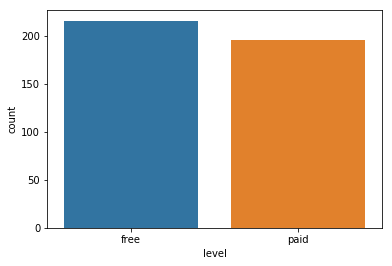

In [18]:
df_pd_level = df_level.select('level').toPandas()
ax = sns.countplot(x='level', data=df_pd_level)

 Free use has higher pass use

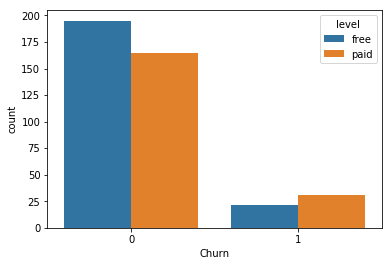

In [19]:
df_pd_churn = df_level.select('level', "Churn").toPandas()
ax = sns.countplot(x='Churn', hue='level', data=df_pd_churn)

We can see that paid user has higher churn rate than free user.

#### Difference between "F" and "M" user in churn rate?

In [20]:
df_gender = df.select("userId", 'gender', 'Churn').distinct()

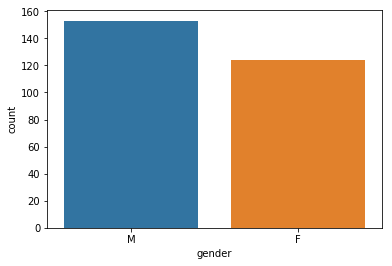

In [21]:
df_pd_gender = df_gender.select('gender').toPandas()
ax = sns.countplot(x='gender', data=df_pd_gender)

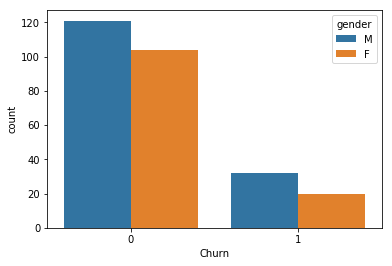

In [22]:
df_pd_churn = df_gender.select('gender', 'Churn').toPandas()
ax = sns.countplot(x='Churn', hue='gender', data=df_pd_churn)

Male user is greater than female user

#### What time in a month/year does user cancel the subcription highest?

In [23]:
df_month = df.select('userId', 'datetime', 'Churn')

df_month = df_month.withColumn('year', F.year('datetime')) \
    .withColumn('month', F.month('datetime')) \
    .withColumn('day', F.dayofmonth('datetime')) \
    .withColumn('hour', F.hour('datetime'))

df_month.show(5)

+------+-------------------+-----+----+-----+---+----+
|userId|           datetime|Churn|year|month|day|hour|
+------+-------------------+-----+----+-----+---+----+
|    30|2018-10-01 00:01:57|    0|2018|   10|  1|   0|
|     9|2018-10-01 00:03:00|    0|2018|   10|  1|   0|
|    30|2018-10-01 00:06:34|    0|2018|   10|  1|   0|
|     9|2018-10-01 00:06:56|    0|2018|   10|  1|   0|
|    30|2018-10-01 00:11:16|    0|2018|   10|  1|   0|
+------+-------------------+-----+----+-----+---+----+
only showing top 5 rows



In [24]:
df_month.groupBy('month').sum('Churn').sort('month').show()

+-----+----------+
|month|sum(Churn)|
+-----+----------+
|   10|        30|
|   11|        22|
|   12|         0|
+-----+----------+



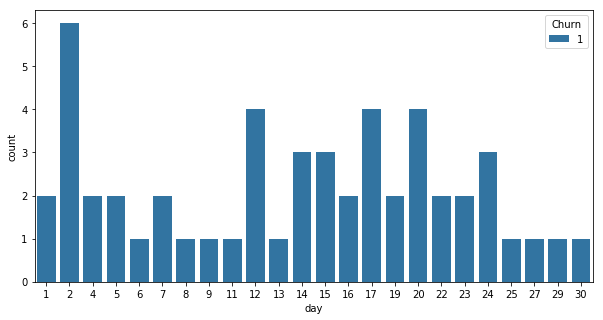

In [25]:
df_pd_month = df_month.filter(F.col('Churn') == 1).toPandas()
plt.figure(figsize = (10, 5))
ax = sns.countplot(x='day', hue='Churn', data=df_pd_month)

The day with the highest churn rate is at the beginning of the month, which is the 2nd.

#### Does user who not very active result in cancellation?

In [26]:
df_churn_user = df.filter(F.col('Churn') == 1)

df_churn_user = df_churn_user.select(F.col('userId').alias('churn_userId'))

df_churn_log = df.join(
    df_churn_user,
    df.userId == df_churn_user.churn_userId,
    'inner'
).drop('churn_userId')

df_churn_log.show(5)

+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+--------------------+------+-------------------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|                song|status|           userAgent|userId|           datetime|Churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+--------------------+------+-------------------+-----+
| Christopher O'Riley|Logged In|    Mason|     M|            0|    Hart|337.91955| free|Corpus Christi, TX|   PUT|NextSong|1533157139000|      174|    paranoid android|   200|"Mozilla/5.0 (Mac...|   125|2018-10-12 04:05:44|    0|
|The Notorious B.I.G.|Logged In|    Mason|     M|            1|    Hart|230.0338

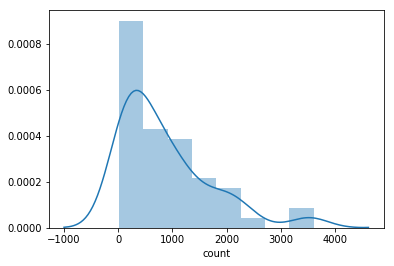

In [27]:
df_pd_dist = df_churn_log.groupBy('userId').count().toPandas()
ax = sns.distplot(df_pd_dist['count'])

The user is not very active before canceling the subscription.

#### Does user still use Sparkify after cancel the subscription?

In [28]:
window = Window.partitionBy("userId").orderBy("datetime").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_cancel = df_churn_log.withColumn("max_datetime", F.max("datetime").over(window))
df_cancel.show(5)

+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+--------------------+------+-------------------+-----+-------------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|                song|status|           userAgent|userId|           datetime|Churn|       max_datetime|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+--------------------+------+-------------------+-----+-------------------+
| Christopher O'Riley|Logged In|    Mason|     M|            0|    Hart|337.91955| free|Corpus Christi, TX|   PUT|NextSong|1533157139000|      174|    paranoid android|   200|"Mozilla/5.0 (Mac...|   125|2018-10-12 04:05:44|    0|2018-10-12 04:35:18|


In [29]:
df_cancel = df_cancel.filter(F.col('datetime') == F.col('max_datetime'))

In [30]:
df_cancel.select('artist').distinct().collect()

[Row(artist=None)]

After canceling the subscription, no one continues to use Sparkify

##### After checking or exploring data on above steps we summary all steps clean data into below function so that using in the next steps(featuring steps)

In [31]:
def clean_data(df):
    """generate features based on df_clean
    
    Param:
        df: original data set
    
    Return:
        df_clean: data frame with missing userId handeled, timestamp transferred, userAgent and location simplified and extra columns deleted
    """
    
    # droping invalid userIds (empty string IDs might represent the visitors of the website who did not register)
    df_clean = df.filter(df["userId"] != "")     
       
    # create column "state" with Abbreviation of US states extracted from "location" column
    df_clean = df_clean.withColumn('state', trim(split(col('location'),',').getItem(1)))
    
    # convert ts to epoch time and create month, date, hour columns out of it
    df_clean = df_clean.withColumn('epoch_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    df_clean = df_clean.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
    
    # simplify "userAgent"
    agent = udf(lambda x: str(re.findall(r'\((.*?)\)', x)[0].split(";")[0].split()[0]) if x is not None else None, StringType())
    df_clean = df_clean.withColumn("agent", agent(df_clean.userAgent))
    
    # drop columns
    df_clean = df_clean.drop('location','auth','firstName','lastName','method','status','userAgent')
    
    return df_clean

In [32]:
def define_churn_downgrade(df_clean):
    """lable churn and downgrade on df_clean
    
    Param:
        df_clean: clean data set
    
    Return:
        df_clean: data frame with churned and downgraded users labeled as "1" and stayed and not downgraded users labeled as "0"
    """
    
    # Using the "Cancellation Confirmation" events to define churn with label 1 and 0 for not
    flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df_clean = df_clean.withColumn("Churn", flag_churn_event("page"))

    # add churn user flag
    df_clean = df_clean.withColumn("label", max('Churn').over(Window.partitionBy('UserId')))
    
    # Flag users who downgraded at least once as 1 and users who never downgraded as 0.
    flag_downgrade_event = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
    df_clean = df_clean.withColumn("Downgrade", flag_downgrade_event("page"))

    # add downgraded user flag
    df_clean = df_clean.withColumn("downgraded", max('Downgrade').over(Window.partitionBy('UserId')))
    
    # delete 'Downgrade','Churn' columns
    df_clean = df_clean.drop('Downgrade','Churn')
    
    return df_clean

In [33]:
df_clean = clean_data(df_org)

In [34]:
df_clean = define_churn_downgrade(df_clean)

In [35]:
# create subset data
df_page = df_clean.select('label','userId','page','date')

In [36]:
df_clean.show(5)

+--------------------+------+-------------+---------+-----+---------+-------------+---------+--------------------+-------------+------+-----+-------------------+----------+------+-----+----------+
|              artist|gender|itemInSession|   length|level|     page| registration|sessionId|                song|           ts|userId|state|         epoch_time|      date| agent|label|downgraded|
+--------------------+------+-------------+---------+-----+---------+-------------+---------+--------------------+-------------+------+-----+-------------------+----------+------+-----+----------+
|Sleeping With Sirens|     F|            0|202.97098| free| NextSong|1538016340000|       31|Captain Tyin Knot...|1539003534000|100010|   CT|2018-10-08 12:58:54|2018-10-08|iPhone|    0|         0|
|Francesca Battist...|     F|            1|196.54485| free| NextSong|1538016340000|       31|Beautiful_ Beauti...|1539003736000|100010|   CT|2018-10-08 13:02:16|2018-10-08|iPhone|    0|         0|
|              

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [37]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- Churn: integer (nullable = false)



In [38]:
df_feature = df.select('userId', 'level', 'gender', 'Churn', 'datetime', 'length', 'artist', 'song', 'page')

In [39]:
# Create features

df_by_user = df_feature.groupBy('userId').agg(
    F.avg('length').alias('avg_song_length'),
    F.countDistinct('artist').alias('total_artist'),
    F.countDistinct('song').alias('total_song'),
    F.count('page').alias('total_session'),
    F.count(F.when(F.col('page') == 'Thumbs Up', True)).alias('total_thumb_up'),
    F.count(F.when(F.col('page') == 'Thumbs Down', True)).alias('total_thumb_down'),
    F.count(F.when(F.col('page') == 'Add Friend', True)).alias('total_add_friend'),
    F.count(F.when(F.col('page') == 'Add to Playlist', True)).alias('total_add_playlist')
)
df_by_user.show(5)

+------+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+
|userId|   avg_song_length|total_artist|total_song|total_session|total_thumb_up|total_thumb_down|total_add_friend|total_add_playlist|
+------+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+
|100010|  243.421444909091|         252|       269|          381|            17|               5|               4|                 7|
|200002|242.91699209302305|         339|       378|          474|            21|               6|               4|                 8|
|   125|261.13913750000006|           8|         8|           11|             0|               0|               0|                 0|
|    51|247.88055082899118|        1385|      1854|         2464|           100|              21|              28|                52|
|   124|248.17653659965674|        2232|      3339|         48

In [40]:
# Keep latest records

window = Window.partitionBy("userId").orderBy("datetime").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_user = df_feature.withColumn("max_datetime", F.max("datetime").over(window))
df_user = df_user.filter(F.col('datetime') == F.col('max_datetime'))
df_user.show(5)

+------+-----+------+-----+-------------------+------+------+----+--------------------+-------------------+
|userId|level|gender|Churn|           datetime|length|artist|song|                page|       max_datetime|
+------+-----+------+-----+-------------------+------+------+----+--------------------+-------------------+
|100010| free|     F|    0|2018-11-21 18:12:32|  null|  null|null|              Logout|2018-11-21 18:12:32|
|200002| paid|     M|    0|2018-11-15 23:25:54|  null|  null|null|           Thumbs Up|2018-11-15 23:25:54|
|   125| free|     M|    0|2018-10-12 04:35:18|  null|  null|null|              Cancel|2018-10-12 04:35:18|
|   125| free|     M|    1|2018-10-12 04:35:18|  null|  null|null|Cancellation Conf...|2018-10-12 04:35:18|
|   124| paid|     F|    0|2018-11-30 15:12:46|  null|  null|null|                Home|2018-11-30 15:12:46|
+------+-----+------+-----+-------------------+------+------+----+--------------------+-------------------+
only showing top 5 rows



In [41]:
# Keep record that "Churn" = 1, otherwise 0

df_user = df_user.withColumn('sum_churn', F.sum('Churn').over(Window.partitionBy("userId")))
df_user = df_user.filter(~((F.col('Churn') == 0) & (F.col('sum_churn') > 0)))

df_user.show(5)

+------+-----+------+-----+-------------------+------+------+----+--------------------+-------------------+---------+
|userId|level|gender|Churn|           datetime|length|artist|song|                page|       max_datetime|sum_churn|
+------+-----+------+-----+-------------------+------+------+----+--------------------+-------------------+---------+
|100010| free|     F|    0|2018-11-21 18:12:32|  null|  null|null|              Logout|2018-11-21 18:12:32|        0|
|200002| paid|     M|    0|2018-11-15 23:25:54|  null|  null|null|           Thumbs Up|2018-11-15 23:25:54|        0|
|   125| free|     M|    1|2018-10-12 04:35:18|  null|  null|null|Cancellation Conf...|2018-10-12 04:35:18|        1|
|   124| paid|     F|    0|2018-11-30 15:12:46|  null|  null|null|                Home|2018-11-30 15:12:46|        0|
|    51| paid|     M|    1|2018-10-17 07:39:32|  null|  null|null|Cancellation Conf...|2018-10-17 07:39:32|        1|
+------+-----+------+-----+-------------------+------+--

In [42]:
df_user = df_user.select('userId', 'level', 'gender', 'Churn').distinct()

df_merge = df_by_user.join(df_user, 'userId', 'left').drop('userId')
df_merge.show(5)


+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+-----+------+-----+
|   avg_song_length|total_artist|total_song|total_session|total_thumb_up|total_thumb_down|total_add_friend|total_add_playlist|level|gender|Churn|
+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+-----+------+-----+
|  243.421444909091|         252|       269|          381|            17|               5|               4|                 7| free|     F|    0|
|242.91699209302305|         339|       378|          474|            21|               6|               4|                 8| paid|     M|    0|
|261.13913750000006|           8|         8|           11|             0|               0|               0|                 0| free|     M|    1|
|248.17653659965674|        2232|      3339|         4825|           171|              41|              74|               11

In [43]:
df_final = df_merge.withColumn("level", F.when(F.col("level") == "paid", 1).otherwise(0)) \
    .withColumn("gender", F.when(F.col("gender") == "M", 1).otherwise(0))

df_final.show(5)

+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+-----+------+-----+
|   avg_song_length|total_artist|total_song|total_session|total_thumb_up|total_thumb_down|total_add_friend|total_add_playlist|level|gender|Churn|
+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+-----+------+-----+
|  243.421444909091|         252|       269|          381|            17|               5|               4|                 7|    0|     0|    0|
|242.91699209302305|         339|       378|          474|            21|               6|               4|                 8|    1|     1|    0|
|261.13913750000006|           8|         8|           11|             0|               0|               0|                 0|    0|     1|    1|
|248.17653659965674|        2232|      3339|         4825|           171|              41|              74|               11

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


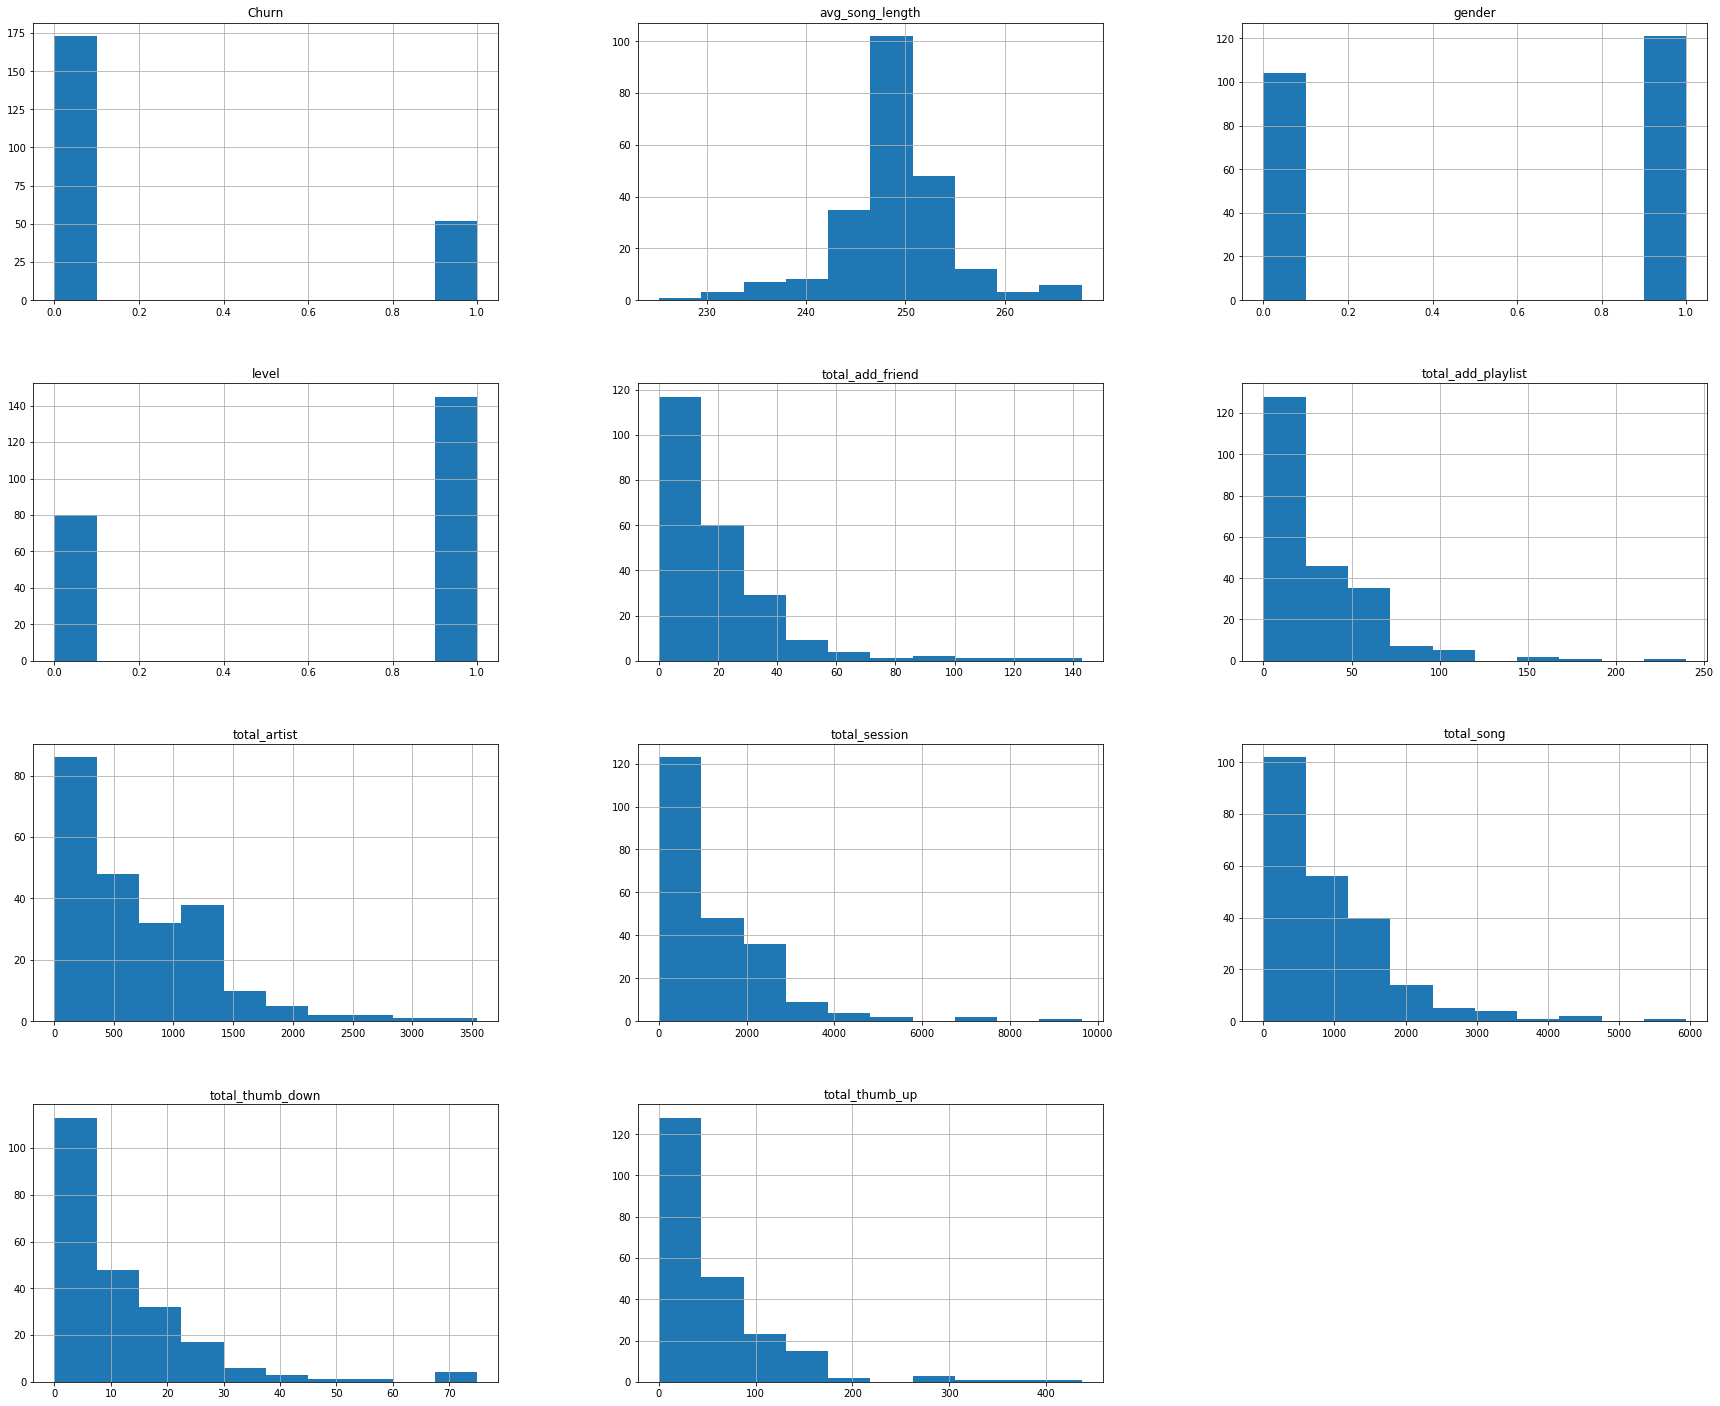

In [44]:
df_pd_final = df_final.toPandas()

fig = plt.figure(figsize=(30, 25))
ax = fig.gca()
h = df_pd_final.hist(ax=ax)

### Prepare features

In [45]:
def prepare_features(df_clean):
    """generate features based on df_clean
    
    Param:
        df_clean: cleaned data frame from which all features are generated
    
    Return:
        df_model: data frame with all necessary features
    """
    
    # add feature "registered days"
    cancellation_df = df_clean.select('userId','ts')\
                              .groupBy('userId')\
                              .agg(max('ts')\
                              .alias('lastinteraction'))
    df_clean = cancellation_df.join(df_clean, on='userId')\
                              .withColumn('registered_days', 
                                          ((col('lastinteraction')-col('registration'))/86400000)
                              .cast(IntegerType()))
    df_clean = df_clean.drop('lastinteraction','registration')
    del cancellation_df
    
    # add feature "latest level of users before they churn"
    level_df = df_clean.select('ts','userId','level')\
                       .orderBy('ts', ascending=False)\
                       .groupBy('userId')\
                       .agg(first('level')\
                       .alias('valid_level'))    
    df_clean = df_clean.drop('level')
    df_clean = df_clean.join(level_df, on='userId')
    del level_df
    
    # add feature "Number of songs per day"
    temp_daily_song = df_clean.select('userId','date','song')\
                              .groupBy('userId','date')\
                              .agg(countDistinct('song')\
                              .alias('songs'))\
                              .sort('userId')
    daily_song = temp_daily_song.groupBy('userId')\
                                .avg('songs')\
                                .withColumnRenamed('avg(songs)',
                                                   'avg_daily_song')
    df_clean = df_clean.join(daily_song, on='userId')
    del temp_daily_song,daily_song
   
    # add feature "Number of songs per session"
    # create new feature
    song_per_session_df = df_clean.select('page','label', 'userId', 'sessionId')\
                                  .where('page == "NextSong"')\
                                  .groupby(['label', 'userId', 'sessionId'])\
                                  .count()\
                                  .groupby(['label', 'userId'])\
                                  .agg({'count': 'avg'})\
                                  .withColumnRenamed('avg(count)', 
                                                     'songs_per_session')
    df_clean = df_clean.join(song_per_session_df.drop('label'), on='userId')
    del song_per_session_df
    
    # add feature "average session duration"
    # session duration for each user
    session_duration = df_clean.select('userId','sessionId','ts')\
                               .groupBy('userId','sessionId')\
                               .agg(((max('ts')-min('ts'))/1000/3600)\
                               .alias('activesession'))
    # average session duration for each user
    session_duration_df = session_duration.groupBy('userId')\
                                          .avg('activesession')\
                                          .withColumnRenamed('avg(activesession)',
                                                             'avg_session')
    # join dataframe to create new column
    df_clean = df_clean.join(session_duration_df, on='userId')
    del session_duration,session_duration_df
    
    # add feature "Friends added"
    # average number of friends added daily
    daily_friends_df = df_page.where('page == "Add Friend"').groupby(['label', 'userId','date']).count()\
        .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'friends')
    
    # join dataframe to create new column "friends"
    df_clean = df_clean.join(daily_friends_df.drop('label'), on='userId',how='left')
    del daily_friends_df
    
    # add feature "number of thumb ups"
    # average number of "thumbs up" daily
    thumbs_up_df = df_page.where('page == "Thumbs Up"').groupby(['label', 'userId','date']).count()\
        .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'thumbs_ups')

    # join dataframe to create new column "thumbs_ups"
    df_clean = df_clean.join(thumbs_up_df.drop('label'), on='userId',how='left')
    del thumbs_up_df
    
    # add feature "number of "thumbs down"
    # average number of "thumbs down" daily
    thumbs_down_df = df_page.where('page == "Thumbs Down"').groupby(['label', 'userId','date']).count()\
        .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'thumbs_downs')
    
    # join dataframe to create new column "thumbs_down"
    df_clean = df_clean.join(thumbs_down_df.drop('label'), on='userId',how='left')
    del thumbs_down_df
    
    # add feature "Times to add to playlist"
    # average number of "add to playlist" 
    add_playlist_df = df_page.where('page == "Add to Playlist"').groupby(['label', 'userId','date']).count()\
        .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'add_playlist')
    
    # join dataframe to create new column "add_playlist"
    df_clean = df_clean.join(add_playlist_df.drop('label'), on='userId',how='left')
    del add_playlist_df
    
    # add feature "times to roll advert"
    # average number of "roll advert" 
    roll_advert_df = df_page.where('page == "Roll Advert"').groupby(['label', 'userId','date']).count()\
        .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'roll_advert')

    # join dataframe to create new column "roll_advert"
    df_clean = df_clean.join(roll_advert_df.drop('label'), on='userId',how='left')
    del roll_advert_df
    
    # assemble features for modeling
    df_model = df_clean.select(['userId',
                                   'label',
                                   'downgraded',
                                   'gender',
                                   'valid_level',
                                   'agent',
                                   'registered_days',
                                   'avg_daily_song',
                                   'songs_per_session',
                                   'avg_session',
                                   'friends',
                                   'thumbs_ups',
                                   'thumbs_downs',
                                   'add_playlist',
                                   'roll_advert']).dropDuplicates(['userId'])
    
    # format decimal
    df_model = df_model.withColumn("daily_song", bround(df_model.avg_daily_song,1))
    df_model = df_model.withColumn("session_song", bround(df_model.songs_per_session,1))
    df_model = df_model.withColumn("session_duration", bround(df_model.avg_session,1))

    # replace missing value with 0
    df_model = df_model.na.fill(0)
    
    # drop old columns
    df_model = df_model.drop('avg_daily_song','songs_per_session','avg_session','userId')

    return df_model

In [46]:
df_features = prepare_features(df_clean)

In [47]:
df_features.columns

['label',
 'downgraded',
 'gender',
 'valid_level',
 'agent',
 'registered_days',
 'friends',
 'thumbs_ups',
 'thumbs_downs',
 'add_playlist',
 'roll_advert',
 'daily_song',
 'session_song',
 'session_duration']

In [48]:
def transform_features(df_model):
    """transfrom the features into the form the model can digest
    
    Param:
        df_model: the data frame with all necessary features.
        
    Return:
        df_model: data data frame ready to be used for modeling.
    """
    
    # Transform categorical columns with StringIndexer
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_model) 
                    for column in ['gender','valid_level','agent'] ]
    pipeline = Pipeline(stages=indexers)
    df_r = pipeline.fit(df_model)\
                   .transform(df_model)
    df_model = df_r.drop('gender','valid_level','agent')
    
    # use StandardScaler to scalerize the created “scaled_feature” column
    # assembeling numeric features to create a vector
    assembler = VectorAssembler(inputCols=['registered_days',
                                           'friends',
                                           'thumbs_ups',
                                           'thumbs_downs',
                                           'add_playlist',
                                           'roll_advert',
                                           'daily_song',
                                           'session_song',
                                           'session_duration'], 
                                outputCol="features")
    
    # use the transform method to transform df
    df_model = assembler.transform(df_model)
    
    # standardize numeric feature vector
    standardscaler=StandardScaler().setInputCol("features")\
                                   .setOutputCol("Scaled_features")
    df_model = standardscaler.fit(df_model)\
                             .transform(df_model)
 
    # Combine all features in one single feature vector
    assembler = VectorAssembler(inputCols=['Scaled_features',
                                           'downgraded',
                                           'gender_index',
                                           'valid_level_index',
                                           'agent_index'],
                                outputCol='exp_features')
    
    # use the transform method to transform df
    df_model = assembler.transform(df_model)
    
    return df_model

In [49]:
df_model = transform_features(df_features)

In [50]:
df_model = df_model.select('label','exp_features')

In [51]:
df_model.count()

225

In [52]:
df_model.cache()
df_model

DataFrame[label: int, exp_features: vector]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Train test split

As a first step break your data set into 80% of training data and set aside 20%. Set random seed to 42.

In [53]:
rest, validation = df_model.randomSplit([0.8, 0.2], seed=42)
print('The number of training examples are {}'.format(rest.count()))
print('The number of test examples are {}'.format(validation.count()))

The number of training examples are 191
The number of test examples are 34


#### Check imbalance in the dataset

In [54]:
dataset_size = float(rest.select('label').count())
numPositives = rest.select('label').where('label == 1').count()
per_ones = (float(numPositives)/float(dataset_size))*100
numNegatives = float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 42
Percentage of ones are 21.98952879581152


#### Class weighing

In [55]:
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.7801047120418848


In [56]:
# creating a new column named “classWeights” in the “rest” dataset
rest = rest.withColumn("classWeights", when(rest.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
rest.select("classWeights").show(5)

+------------------+
|      classWeights|
+------------------+
|0.2198952879581152|
|0.7801047120418848|
|0.2198952879581152|
|0.7801047120418848|
|0.7801047120418848|
+------------------+
only showing top 5 rows



In [57]:
rest.cache()
validation.cache()

DataFrame[label: int, exp_features: vector]

In [58]:
def model_eval(model, train_data, valid_data,verbose=False):
    """Train the model given training data set and evaluate on validation data set and return the evaluation metrics
    
    Param:
        model: the spark machine learning model for classification
        train_data: spark data frame for training data set
        valid_data: spark data frame for validation data set
        verbose: boolean indicator of showing the model result or not
    Return:
        result: a dictionary including F1 score, AUC score and feature importance
    """
    
    fitted_model = model.fit(train_data)

    
    exp_features = ['registered_days',
                    'friends',
                    'thumbs_ups',
                    'thumbs_downs',
                    'add_playlist',
                    'roll_advert',
                    'daily_song',
                    'session_song',
                    'session_duration',
                    'downgraded',
                    'gender_index',
                    'valid_level_index',
                    'agent_index']
    
    predict_rest = fitted_model.transform(train_data)
    predict_val = fitted_model.transform(valid_data)

    #F1 score
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score_rest = f1_score_evaluator.evaluate(predict_rest.select(col('label'), col('prediction')))
    f1_score_val = f1_score_evaluator.evaluate(predict_val.select(col('label'), col('prediction')))

    #AUC
    auc_evaluator = BinaryClassificationEvaluator()
    roc_value_rest = auc_evaluator.evaluate(predict_rest, {auc_evaluator.metricName: "areaUnderROC"})
    roc_value_val = auc_evaluator.evaluate(predict_val, {auc_evaluator.metricName: "areaUnderROC"})
    
    if verbose:
        print('The F1 score on the train set is {:.2%}'.format(f1_score_rest))
        print('The F1 score on the test set is {:.2%}'.format(f1_score_val)) 
        print('The areaUnderROC on the train set is {:.2%}'.format(roc_value_rest))
        print('The areaUnderROC on the test set is {:.2%}'.format(roc_value_val))
    
    ## feature importances
    if isinstance(model, LogisticRegression):
        FI = fitted_model.coefficients
        model_FI = pd.DataFrame(list(zip(exp_features, FI)), 
                                columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)
        if verbose:
            model_FI.plot.bar(x='Feature', y='Coefficient')
            plt.ylabel('Coefficient')
            
    if isinstance(model, RandomForestClassifier) or isinstance(model, GBTClassifier):
        FI = fitted_model.featureImportances
        model_FI = pd.DataFrame(list(zip(exp_features, FI)), 
                                columns=['Feature', 'FeatureImportances']).sort_values('FeatureImportances', ascending=False)
        if verbose:
            model_FI.plot.bar(x='Feature', y='FeatureImportances')
            plt.ylabel('FeatureImportances')
   
    if isinstance(model,CrossValidator):
        FI = fitted_model.bestModel.featureImportances
        model_FI = pd.DataFrame(list(zip(exp_features, FI)), 
                                columns=['Feature', 'FeatureImportances']).sort_values('FeatureImportances', ascending=False)
        if verbose:
            model_FI.plot.bar(x='Feature', y='FeatureImportances')
            plt.ylabel('FeatureImportances')
    
    if verbose:
        # visualizing fearue importances
        plt.title('Feature importance of'+ str(type(model)))
        plt.xlabel('Features')
        plt.xticks(rotation=45, ha='right')
        plt.show()

    result = {}
    result['f1_score_rest'] = f1_score_rest
    result['f1_score_val'] = f1_score_val
    result['roc_value_rest'] = roc_value_rest
    result['roc_value_val'] = roc_value_val
    result['model_FI']=model_FI
    
    return result

#### Logistic regression model

The F1 score on the train set is 74.38%
The F1 score on the test set is 73.10%
The areaUnderROC on the train set is 79.43%
The areaUnderROC on the test set is 76.25%


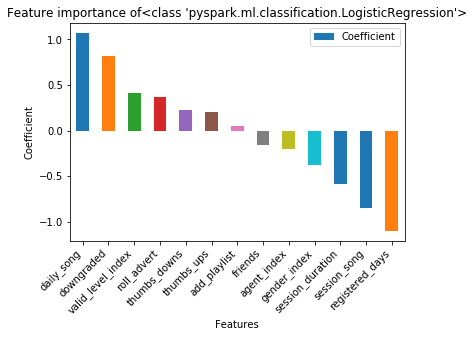

{'f1_score_rest': 0.7438047080348289,
 'f1_score_val': 0.731029253806786,
 'roc_value_rest': 0.7943432406519648,
 'roc_value_val': 0.7625000000000001,
 'model_FI':               Feature  Coefficient
 6          daily_song     1.070573
 9          downgraded     0.813533
 11  valid_level_index     0.417123
 5         roll_advert     0.374592
 3        thumbs_downs     0.224694
 2          thumbs_ups     0.203438
 4        add_playlist     0.052124
 1             friends    -0.152221
 12        agent_index    -0.198234
 10       gender_index    -0.378273
 8    session_duration    -0.582143
 7        session_song    -0.843315
 0     registered_days    -1.095416}

In [59]:
lr = LogisticRegression(labelCol="label", featuresCol="exp_features",weightCol="classWeights",maxIter=10)
result_lr = model_eval(lr, rest, validation, verbose=True)
result_lr

#### Random forest model

The F1 score on the train set is 90.85%
The F1 score on the test set is 70.31%
The areaUnderROC on the train set is 98.31%
The areaUnderROC on the test set is 73.75%


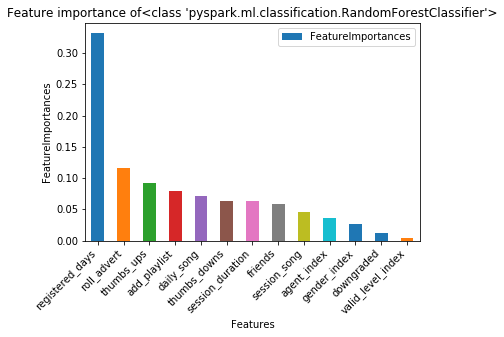

{'f1_score_rest': 0.9085093736697668,
 'f1_score_val': 0.7030812324929971,
 'roc_value_rest': 0.9830616810482582,
 'roc_value_val': 0.7375,
 'model_FI':               Feature  FeatureImportances
 0     registered_days            0.331262
 5         roll_advert            0.116667
 2          thumbs_ups            0.091843
 4        add_playlist            0.079476
 6          daily_song            0.070926
 3        thumbs_downs            0.064037
 8    session_duration            0.062564
 1             friends            0.058484
 7        session_song            0.045797
 12        agent_index            0.035539
 10       gender_index            0.026889
 9          downgraded            0.011889
 11  valid_level_index            0.004627}

In [60]:
rf = RandomForestClassifier(labelCol="label", featuresCol="exp_features")
result_rf = model_eval(rf, rest, validation, verbose=True)
result_rf

#### Gradient boosted tree model

The F1 score on the train set is 99.47%
The F1 score on the test set is 68.04%
The areaUnderROC on the train set is 100.00%
The areaUnderROC on the test set is 64.58%


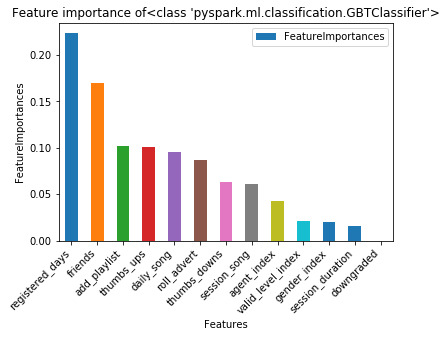

{'f1_score_rest': 0.9947416133215556,
 'f1_score_val': 0.6804298642533937,
 'roc_value_rest': 1.0,
 'roc_value_val': 0.6458333333333334,
 'model_FI':               Feature  FeatureImportances
 0     registered_days            0.223323
 1             friends            0.169686
 4        add_playlist            0.101518
 2          thumbs_ups            0.100753
 6          daily_song            0.095390
 5         roll_advert            0.086766
 3        thumbs_downs            0.062618
 7        session_song            0.060988
 12        agent_index            0.042665
 11  valid_level_index            0.020857
 10       gender_index            0.020020
 8    session_duration            0.015416
 9          downgraded            0.000000}

In [61]:
# Initialize Gradient-Boosted Tree object
gbt = GBTClassifier(labelCol="label", featuresCol="exp_features", maxIter=10)
result_gbt = model_eval(gbt, rest, validation, verbose=True)
result_gbt

#### Hyperparameter tuning (Future Steps)


In [62]:
# evaluate model
# rfevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")

# create ParamGrid for Cross Validation
# rfparamGrid = (ParamGridBuilder()
#              .addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
             #  .addGrid(rf.maxDepth, [2, 5, 10])
#              .addGrid(rf.maxBins, [10, 20, 40, 80, 100])
             #  .addGrid(rf.maxBins, [5, 10, 20])
#              .addGrid(rf.numTrees, [5, 20, 50, 100, 500])
             #  .addGrid(rf.numTrees, [5, 20, 50])
#              .build())

# create 5-fold CrossValidator
# rfcv = CrossValidator(estimator = rf,
#                       estimatorParamMaps = rfparamGrid,
#                       evaluator = rfevaluator,
#                       numFolds = 5)
# result_rfcv = model_eval(rfcv, rest, validation, verbose=True)
# result_rfcv

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.